In [1]:
!pip install CBFV
from CBFV.composition import generate_features

     |████████████████████████████████| 539 kB 8.9 MB/s 


In [2]:
import os
import keras
import sys
import pandas as pd
import tensorflow as tf
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

from keras import initializers #API : Google | Pytorch from facebook
from keras.layers import Dense
from keras.models import Sequential
# from keras import optimizers
from tensorflow.keras import optimizers # keras installed from tensorflow

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize


import data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH = os.getcwd()
data_path = os.path.join(PATH, '/content/drive/MyDrive/jupyter/2D/data/C2DB_clean.csv')
df = pd.read_csv(data_path)

df.head(10)

,Formula,Band gap
0,As4O8,3.232
1,Ca4As4,0.998
2,In2Se2,1.630
3,Sc4S6,1.515
4,V2O5,1.356
5,Zr2Te10,0.191
6,Al2MgSe4,1.064
7,Cr2Br2O2,0.501
8,Hf2Ge2Te8,0.565
9,In4I4Te4,1.732


## Generate features using the `CBFV` package

To featurize the chemical compositions from a chemical formula (e.g. "Al2O3") into a composition-based feature vector (CBFV), we use the open-source [`CBFV` package](https://github.com/kaaiian/CBFV).

The `generate_features` function from the CBFV package expects an input DataFrame containing at least the columns `['formula', 'target']`. You may also have extra feature columns (e.g., `temperature` or `pressure`, other measurement conditions, etc.).

Since the `generate_features` function expects the target variable column to be named `target`, we have to rename 


In [5]:
rename_dict = {'Formula': 'formula', 'Band gap': 'target'}
df = df.rename(columns=rename_dict)
df.head()

,formula,target
0,As4O8,3.232
1,Ca4As4,0.998
2,In2Se2,1.630
3,Sc4S6,1.515
4,V2O5,1.356


Now we can use the `generate_features` function to generate the CBFVs from the input data.

Note that we have specified several keyword arguments in our call to `generate_features`:
* `elem_prop='oliynyk'`
* `drop_duplicates=False`
* `extend_features=True`
* `sum_feat=True`

A short explanation for the choice of keyword arguments is below:
* The `elem_prop` parameter specifies which CBFV featurization scheme to use (there are several). For this tutorial, we have chosen to use the `oliynyk` CBFV featurization scheme.
* The `drop_duplicates` parameter specifies whether to drop duplicate formulae during featurization.
* The `extend_features` parameter specifies whether to include extended features (features that are not part of `['formula', 'target']`) in the featurized data.
* The `sum_feat` parameter specifies whether to calculate the sum features when generating the CBFVs for the chemical formulae. We do in our case (`True`).


In [6]:
X_train_unscaled, y_train, formulae_train, skipped_train = generate_features(df, elem_prop='oliynyk', drop_duplicates=False, extend_features=False, sum_feat=True)

Processing Input Data: 100%|██████████| 1450/1450 [00:00<00:00, 18214.59it/s]


	Featurizing Compositions...


Assigning Features...: 100%|██████████| 1450/1450 [00:00<00:00, 7519.66it/s]


	Creating Pandas Objects...


## Splitting data 
### Normally, we could simply split the data with a simple `sklearn` function



In [7]:
SEED = 42
X_train_unscaled, X_test_unscaled, y_train, y_test = train_test_split(X_train_unscaled, y_train, test_size=0.20, random_state=SEED)


## Data scaling & normalization

For numerical input data, scaling and normalization of the features often improves the model performance.
Scaling can partially correct the discrepancy between the orders of magnitudes of the features (e.g., some numerical features being much larger or smaller than others).
This typically improves the model learning performance, and in turn, improves the model performance.

We will scale then normalize our input data using scikit-learn's built-in `StandardScaler` class and `normalize` function.

Note, in addition to `StandardScaler`, other scalers such as `RobustScaler` and `MinMaxScaler` are also available in scikit-learn.

## Scaling the data

First, we instantiate the scaler object.

In a `StandardScaler` object:
* During the `fit` process, the statistics of the input data (mean and standard deviation) are computed.
* Then, during the `transform` process, the mean and standard deviation values calculated above are used to scale the data to having zero-mean and unit variance.

Therefore, for the first time usage of the scaler, we call the `.fit_transform()` method to fit the scaler to the input data, and then to transform the same data.
For subsequent uses, since we have already computed the statistics, we only call the `.transform()` method to scale data.

**Note:** you should *only* `.fit()` the scaler using the training dataset statistics, and then use these same statistics from the training dataset to `.transform()` the other datasets (validation and train).

In [8]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train_unscaled)
# X_val = scaler.transform(X_val_unscaled)
X_test = scaler.transform(X_test_unscaled)

### 3. Creating the Model

For this regression, we will use a simple sequential neural network with one densely connected hidden layer. The optimizer used will be [RMSPropOptimizer](https://www.tensorflow.org/api_docs/python/tf/train/RMSPropOptimizer) (Root Mean Square Propagation).

To learn more about Root Mean Squared Propagation, click [here](https://climin.readthedocs.io/en/latest/rmsprop.html).


In [19]:
# !pip install talos

In [20]:
# # first we have to make sure to input data and params into the function
# def breast_cancer_model(x_train, y_train, x_val, y_val, params):
    
#     from tensorflow.keras.layers import Dense, Dropout
#     from tensorflow.keras.models import Sequential

#     model = Sequential()
#     model.add(Dense(params['first_neuron'], input_dim=x_train.shape[1],
#                     activation=params['activation'],
#                     kernel_initializer=params['kernel_initializer']))

#     model.add(Dropout(params['dropout']))

#     model.add(Dense(1, activation=params['last_activation'],
#                     kernel_initializer=params['kernel_initializer']))

#     model.compile(loss=params['losses'],
#                   optimizer=params['optimizer'],
#                   metrics=['acc', talos.utils.metrics.f1score])

#     history = model.fit(x_train, y_train, 
#                         validation_data=[x_val, y_val],
#                         batch_size=params['batch_size'],
#                         callbacks=[talos.callbacks.TrainingPlot(metrics=['f1score'])],
#                         epochs=params['epochs'],
#                         verbose=0)

#     return history, model

In [21]:
# # then we can go ahead and set the parameter space
# p = {'first_neuron':[9, 10, 11],
#      'hidden_layers':[0, 1, 2],
#      'batch_size': [30],
#      'epochs': [100],
#      'dropout': [0],
#      'kernel_initializer': ['uniform','normal'],
#      'optimizer': ['Nadam', 'Adam'],
#      'losses': ['binary_crossentropy'],
#      'activation':['relu', 'elu'],
#      'last_activation': ['sigmoid']}


In [22]:
# # and run the experiment
# import talos
# t = talos.Scan(x=X_train,
#                y=y_train,
#                model=breast_cancer_model,
#                params=p,
#                experiment_name='breast_cancer',
#                round_limit=50)
#               #  disable_progress_bar=True)

In [38]:
# DEFINITION OF THE MODEL

# The weights of our neural network will be initialized in a random manner, using a seed allows for reproducibility
kernel_init = initializers.RandomNormal(seed=0) #it is the weight
bias_init = initializers.Zeros()
# In a sequential model, the first layer must specify the input shape the model will expect; 
# in this case the value is train_values.shape[1] which is the number
# of attributes (properties) and equals **.

model = Sequential() #declare a model object
# model.add(Dense(number_neurons, activation='activation_function-eg:tanh')) #to add a layer to the model 
model.add(Dense(32, activation='relu', input_shape=(X_train.shape[1], ), kernel_initializer=kernel_init, bias_initializer=bias_init)) #for first one specify input_shape=16(how many inputs) 
model.add(Dense(64, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(128, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
# model.add(Dense(256, activation='relu', kernel_initializer=kernel_init, bias_initializer=bias_init))
model.add(Dense(1, kernel_initializer=kernel_init, bias_initializer=bias_init)) #output layer with only one neuron => output layer ,# set the weight to the values

# DEFINITION OF THE OPTIMIZER

optimizer = optimizers.RMSprop(0.002) # Root Mean Squared Propagation

# This line matches the optimizer to the model and states which metrics will evaluate the model's accuracy
model.compile(loss='mae', optimizer=optimizer, metrics=['mae']) #MAE: Mean Absolute Error
model.summary() #Summarize the model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_17 (Dense)            (None, 32)                9888      
                                                                 
 dense_18 (Dense)            (None, 64)                2112      
                                                                 
 dense_19 (Dense)            (None, 1)                 65        
                                                                 
Total params: 12,065
Trainable params: 12,065
Non-trainable params: 0
_________________________________________________________________


#### TRAINING 

This model is trained for 2000 epochs, and we record the training accuracy in the history object.

One **Epoch** occurs when you pass the entire dataset through the model. One **Batch** contains a subset of the dataset that can be fed to the model at the same time. A more detailed explanation of these concepts can be found in this [blog](https://towardsdatascience.com/epoch-vs-iterations-vs-batch-size-4dfb9c7ce9c9). As we have a really small dataset compared to the ones that are usually considered to be modeled by these neural networks, we are feeding all entries at the same time, so our batch is the entire dataset, and an epoch occurs when the batch is processed.

This way, by plotting "history" we can see the evolution of the "learning" of the model, that is the decrease of the Mean Absolute Error. Models in Keras are fitted to the training set using the [**fit**](https://keras.io/models/model/#fit) method.

The blue curve that will come up from the History object represents how the model is learning on the training data, and the orange curve represents the validation loss, which can be thought of as the way our model evaluates data that it was not trained in. This validation loss would start going up again when we start to overfit our data.

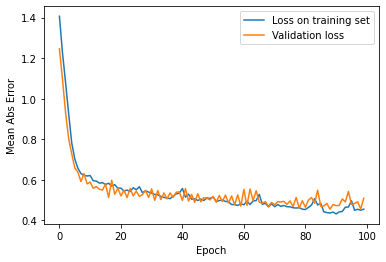

In [39]:
# EPOCH REAL TIME COUNTER CLASS
class PrintEpNum(keras.callbacks.Callback): # This is a function for the Epoch Counter
    def on_epoch_end(self, epoch, logs):
        sys.stdout.flush()
        sys.stdout.write("Current Epoch: " + str(epoch+1) + " Training Loss: " + "%4f" %logs.get('loss') + '                                       \r') # Updates current Epoch Number

EPOCHS = 100 # Number of EPOCHS

# HISTORY Object which contains how the model learned

# Training Values (Properties), Training Labels (Known ) 
history = model.fit(X_train, y_train, batch_size=X_train.shape[0], 
                    epochs=EPOCHS, verbose = False, shuffle=False, validation_split=0.1, callbacks=[PrintEpNum()]) #validation_split is to prevent overfittting


# PLOTTING HISTORY USING MATPLOTLIB

plt.figure()
plt.xlabel('Epoch')
plt.ylabel('Mean Abs Error')
plt.plot(history.epoch, np.array(history.history['mae']),label='Loss on training set') 
plt.plot(history.epoch, np.array(history.history['val_mae']),label = 'Validation loss')
plt.legend()
plt.show()

In [40]:
# from joblib import dump, load

#save model
# dump(model, '/content/drive/MyDrive/jupyter/SuperCon/save_model/NN_oliynyk_e300_32-64.joblib') 
#load model
# model = load('/content/drive/MyDrive/jupyter/SuperCon/save_model/NN_oliynyk_e300_32-64.joblib') 

#### TESTING

Models in Keras are tested using the method [**evaluate**](https://keras.io/models/model/#evaluate). This method returns the testing loss of the model and the metrics we specified when creating it,  which in our case it's the Mean Absolute Error. For the original model in this tutorial you should get a value of **29.59 GPa** for the Mean Absolute Error. This value would decrease with more training data, more attributes/features, or a different optimizer. In the case of a model that overfits, you can expect values to start increasing.

In [41]:
[loss, mae] = model.evaluate(X_test, y_test, verbose=0) # test the model

print("Testing Set Mean Absolute Error: {:2.2f} K".format(mae))

Testing Set Mean Absolute Error: 0.48 K


#### MAKING PREDICTIONS

The last step in a regression model is to make predictions for values not in the training set, which are determined by the method [**predict**](https://keras.io/models/model/#predict). In the following cell we print the elements in the testing set, the real values for their Young's moduli and the predictions generated by our machine learned model.

In [ ]:
test_predictions = model.predict(X_test).flatten()

# print("Elements in Test Set: ", labeled_elements)
print("Real Values", list(y_test))
print("Predictions", list(test_predictions))

values = np.concatenate((X_train, X_test), axis=0) # This line joins the values together to evaluate all of them
predictions = model.predict(values).flatten()
#MY
#print("Elements in Test Set: ", elements)
#print("Real Values", list(all_labels))
#print("Predictions", list(predictions))


Real Values [2.004, 0.032, 3.616, 4.882, 0.168, 0.421, 0.505, 0.938, 0.434, 0.313, 1.887, 0.396, 3.194, 0.704, 0.706, 0.836, 0.249, 0.829, 1.022, 5.738, 0.831, 1.446, 0.672, 4.453, 4.374, 5.729, 0.711, 1.1, 0.393, 0.322, 0.645, 3.496, 2.007, 0.997, 2.352, 0.636, 1.552, 0.091, 2.453, 0.801, 0.692, 1.074, 0.267, 1.233, 0.467, 5.113, 0.706, 3.975, 0.829, 0.065, 2.893, 2.335, 1.954, 0.174, 1.23, 0.781, 1.316, 0.325, 0.11, 0.835, 1.731, 1.052, 2.287, 0.039, 3.885, 1.302, 1.061, 0.449, 3.537, 2.13, 0.134, 2.333, 3.264, 1.069, 1.662, 0.1, 0.432, 0.713, 0.691, 0.12, 0.809, 1.644, 0.956, 2.133, 0.339, 1.069, 2.085, 1.319, 0.443, 0.984, 3.248, 0.679, 0.052, 0.271, 0.863, 0.111, 0.788, 1.597, 1.546, 1.186, 3.897, 0.663, 2.255, 0.878, 0.506, 0.92, 0.951, 3.268, 0.1, 1.748, 0.062, 1.167, 1.126, 1.013, 1.846, 1.532, 0.05, 1.406, 0.845, 3.83, 1.577, 0.449, 0.494, 0.153, 0.819, 0.77, 4.354, 0.774, 0.733, 5.941, 2.125, 1.119, 2.514, 0.803, 0.305, 1.604, 3.815, 0.202, 0.013, 0.697, 0.198, 0.378, 1.157, 

In [ ]:
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 11.5 MB/s 


In [ ]:

metric = tfa.metrics.r_square.RSquare()
metric.update_state(y_test, test_predictions)
result = metric.result()
r2 = result.numpy()
print(r2)

0.6998936


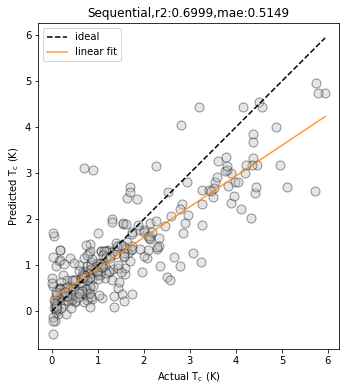

In [ ]:
y_act_test = y_test
y_pred_test = test_predictions

reg_line=True # set true or false
xy_max = np.max([np.max(y_act_test), np.max(y_pred_test)])

plot = plt.figure(figsize=(6,6))
plt.plot(y_act_test, y_pred_test, 'o', ms=9, mec='k', mfc='silver', alpha=0.4)
plt.plot([0, xy_max], [0, xy_max], 'k--', label='ideal')
if reg_line:
    polyfit = np.polyfit(y_act_test, y_pred_test, deg=1)
    reg_ys = np.poly1d(polyfit)(np.unique(y_act_test))
    plt.plot(np.unique(y_act_test), reg_ys, alpha=0.8, label='linear fit')
plt.axis('scaled')
label='$\mathrm{T}_\mathrm{c}$ (K)'
plt.xlabel(f'Actual {label}')
plt.ylabel(f'Predicted {label}')
plt.title(f'{type(model).__name__},r2:{r2:0.4f},mae:{mae:0.4f}')
plt.legend(loc='upper left')
